## Imports and Setup

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import pickle


## Data Preparation

### Data Augmentation and Normalization

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Loading the CIFAR-10 Dataset

In [3]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Visualization Function

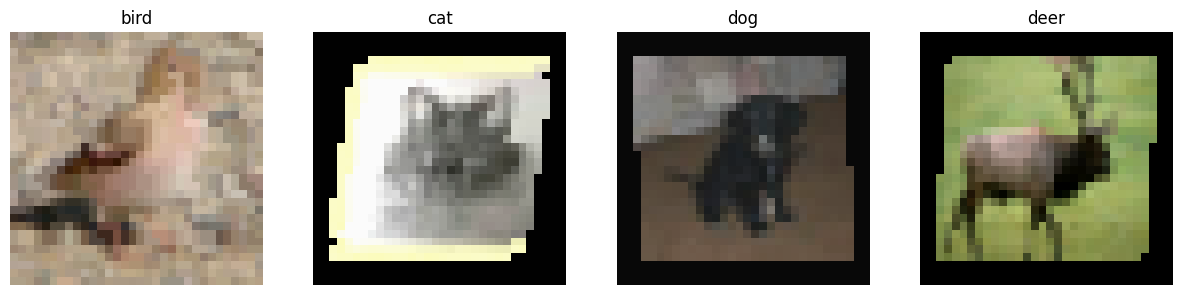

In [4]:
def plot_images(images, labels, classes):
    fig, axes = plt.subplots(1, len(images), figsize=(15,15))
    images = images / 2 + 0.5  # Unnormalize
    for i, ax in enumerate(axes):
        img = images[i].numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.show()

# Load label names for CIFAR-10
data_dir = './data/cifar-10-batches-py'
with open(os.path.join(data_dir, 'batches.meta'), 'rb') as f:
    label_names = pickle.load(f)['label_names']

# Fetch some images and labels from the DataLoader to visualize
data_iter = iter(train_loader)
images, labels = next(data_iter)
plot_images(images, labels.tolist(), label_names)


## Model Definition

### Custom CNN Model

In [5]:
class ModifiedNet(nn.Module):
    def __init__(self):
        super(ModifiedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = ModifiedNet()


### ResNet Model Adaptation

In [6]:
def modify_resnet(model):
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model

resnet = models.resnet18(pretrained=False)
resnet = modify_resnet(resnet)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training and Evaluation Functions

In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
    print('Finished Training')

def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')
    return accuracy


## Training and Testing the Models

### Setup for Custom CNN Model

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(net.parameters(), lr=0.001)

print("Training Custom CNN Model...")
train_model(net, train_loader, criterion, optimizer_custom, num_epochs=10)

print("Evaluating Custom CNN Model...")
accuracy_custom = evaluate_model(net, test_loader)


Training Custom CNN Model...
Epoch 1/10, Loss: 1.8576253107213974
Epoch 2/10, Loss: 1.6883800463414191
Epoch 3/10, Loss: 1.6301735483527184
Epoch 4/10, Loss: 1.5890452156496049
Epoch 5/10, Loss: 1.5642286009073259
Epoch 6/10, Loss: 1.5371494859695434
Epoch 7/10, Loss: 1.5326290872192383
Epoch 8/10, Loss: 1.520405239393711
Epoch 9/10, Loss: 1.5018458702224493
Epoch 10/10, Loss: 1.497139142407179
Finished Training
Evaluating Custom CNN Model...
Accuracy of the network on the 10000 test images: 50.63 %


### Setup for ResNet Model

In [9]:
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

print("Training ResNet Model...")
train_model(resnet, train_loader, criterion, optimizer_resnet, num_epochs=10)

print("Evaluating ResNet Model...")
accuracy_resnet = evaluate_model(resnet, test_loader)


Training ResNet Model...
Epoch 1/10, Loss: 1.6322961593091487
Epoch 2/10, Loss: 1.1146270298734307
Epoch 3/10, Loss: 0.894581292717196
Epoch 4/10, Loss: 0.7708940484458581
Epoch 5/10, Loss: 0.6906068730350584
Epoch 6/10, Loss: 0.6249914787191945
Epoch 7/10, Loss: 0.5741033629724197
Epoch 8/10, Loss: 0.5324566772948718
Epoch 9/10, Loss: 0.4920882902080426
Epoch 10/10, Loss: 0.45586180335235954
Finished Training
Evaluating ResNet Model...
Accuracy of the network on the 10000 test images: 85.48 %


## Comparing Model Performances

In [10]:
print(f"Custom CNN Model Accuracy: {accuracy_custom:.2f} %")
print(f"ResNet Model Accuracy: {accuracy_resnet:.2f} %")

if accuracy_resnet > accuracy_custom:
    print("ResNet performed better than the custom CNN model.")
else:
    print("Custom CNN model performed better than or equal to ResNet.")


Custom CNN Model Accuracy: 50.63 %
ResNet Model Accuracy: 85.48 %
ResNet performed better than the custom CNN model.


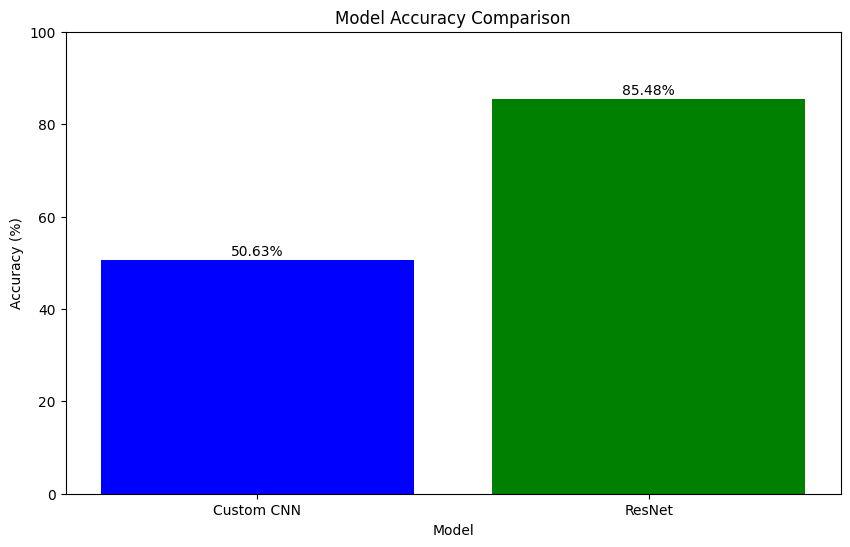

In [11]:
import matplotlib.pyplot as plt

# Accuracy values
accuracies = [50.63, 85.48]
model_names = ['Custom CNN', 'ResNet']

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green'])

# Adding title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis range to show percentages clearly

# Displaying the accuracy values on top of the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 1, f"{accuracy}%", ha = 'center', color = 'black')

# Show the plot
plt.show()
